# MM-WHS: Multi-Modality Whole Heart Segmentation

Данные были собраны в естественных условиях. Поэтому изображения имеют разное качество, некоторые из которых относительно плохое. Это необходимо для проверки надежности разработанных алгоритмов в реальных клинических условиях.

Данные CT/CTA сердца были собраны в ходе обычных КТ ангиографий сердца. Коронарная ангиография - это визуализация коронарных сосудов (кровеносных сосудов, которые снабжают и питают сердце) с помощью окрашенной жидкости. Изображения охватывают все сердце целиком от верхней части брюшной полости до дуги аорты. Срезы 3D изображений по умолчанию предстают в аксиальном ракурсе. The inplane resolution is about 0.78 × 0.78 mm and the average slice thickness is 1.60 mm. The MRI data were acquired using 3D balanced steady state free precession (b-SSFP) sequences, with about 2 mm acquisition resolution at each direction and reconstructed (resampled) into about 1 mm.

Всего в наборе данных представленно порядка 60 CT/CTA изображений сердца взятых из разных медицинских учреждений. Из них 20 изображений отобраны для обучения, а 40 для тестирования. Всего в наборе данных представлена сегментация для 7 отдельных субструктур сердца, в купе формирующих целое его представление. Все клинические данные были одобрены институциональной этикой и анонимизированны. 

+ 500 - кровеносная полость левого желудочка (the left ventricle blood cavity)
+ 600 - кровеносная полость правого желудочка (the right ventricle blood cavity)
+ 420 - кровеносная полость левого предсердия (the left atrium blood cavity)
+ 550 - кровеносная полость правого предсердия (the right atrium blood cavity)
+ 205 - миокард левого желудочка (the myocardium of the left ventricle)
+ 820 - восходящая аорта (the ascending aorta) от аортального клапана (aortic valve) до верхнего уровня предсердий (the superior level of the atria). Средняя длина ствола (trunk) аорты составляет около 41.9 мм
+ 850 - легочная артерия (the pulmonary artery). Определяется как ствол между легочным клапаном (pulmonary valve) и точкой бифуркации (bifurcation point).

Наибольший интерес представляют крупные сосуды, к ним относятся восходящая аорта и легочная артерия. Из-за различных полей зрения их охват на каждом скане может быть разным. Поэтому, чтобы иметь единообразное представление для каждого субъекта, авторы ввели четкие критерии определения границ сосудов. Впрочем,  ручная сегментация как для тренировочных, так и для тестовых данных, как правило, выходит за пределы определенной длины сосудов. При оценке качества сегментации будут учитываться только основные стволы сосудов.

![alt text](https://zmiclab.github.io/zxh/0/mmwhs/res/MMData2.png)

![alt text](https://zmiclab.github.io/zxh/0/mmwhs/res/WholeHeartSegment_ErrorMap_WhiteBg.gif)

Sources:
1. data description [link](https://zmiclab.github.io/zxh/0/mmwhs/data.html)

In [1]:
import os
import numpy as np
import nibabel as nib
from tqdm import tqdm

ROOT_DIR = "/home/cayetana/Storage/code/cayetana-best/heart-segmentation"
DATASET_PATH = "data/datasets/CT_HD_Whole_Heart_Segmentation/train"
os.chdir(ROOT_DIR)

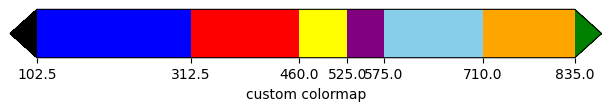

In [2]:
# make custom colormap
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt

label_map = {
    "background": {"color": "black", "value": 0.0},
    "left ventricle": {"color": "yellow", "value": 500.0, "description": "the left ventricle blood cavity"},
    "right ventricle": {"color": "skyblue", "value": 600.0, "description": "the right ventricle blood cavity"},
    "left atrium": {"color": "red", "value": 420.0, "description": "the left atrium blood cavity"},
    "right atrium": {"color": "purple", "value": 550.0, "description": "the right atrium blood cavity"},
    "myocardium": {"color": "blue", "value": 205.0, "description": "the myocardium of the left ventricle"},
    "ascending aorta": {"color": "orange", "value": 820.0, "description": "the ascending aorta"},
    "pulmonary artery": {"color": "green", "value": 850.0, "description": "the pulmonary artery"},
}
label_values = [meta["value"] for meta in label_map.values()]
colors = [value["color"] for value in label_map.values()]
label_values, colors = zip(*sorted(zip(label_values, colors)))

mid_bounds = [(label_values[i] + label_values[i+1]) / 2 for i in range(len(label_values)-1)]
custom_cmap = matplotlib.colors.ListedColormap(list(colors)[1:], N=len(colors)).with_extremes(under='black', over='green')
norm = matplotlib.colors.BoundaryNorm(mid_bounds, custom_cmap.N - 2)

fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')
fig.colorbar(
    matplotlib.cm.ScalarMappable(cmap=custom_cmap, norm=norm),
    cax=ax, orientation='horizontal',
    extend='both',
    spacing='proportional',
    label='custom colormap',
)

## Визуализация 2D данных. NumPy

In [ ]:
images = []
labels = []

for path in tqdm(sorted(os.listdir(DATASET_PATH))):
    if path.endswith("_image.nii.npy"):
        image_path = os.path.join(DATASET_PATH, path)
        images.append(image_path)
    elif path.endswith("_label.nii.npy"):
        label_path = os.path.join(DATASET_PATH, path)
        labels.append(label_path)

len(images), len(labels)

100%|██████████| 202/202 [00:00<00:00, 1619979.75it/s]


(20, 20)

In [ ]:
idx = 0
image = np.load(images[idx])
label = np.load(labels[idx])

image.shape, label.shape

((512, 512, 363), (512, 512, 363))

In [5]:
np.unique(label) # unique pixel values = classes

array([  0., 205., 420., 500., 550., 600., 820., 850.])

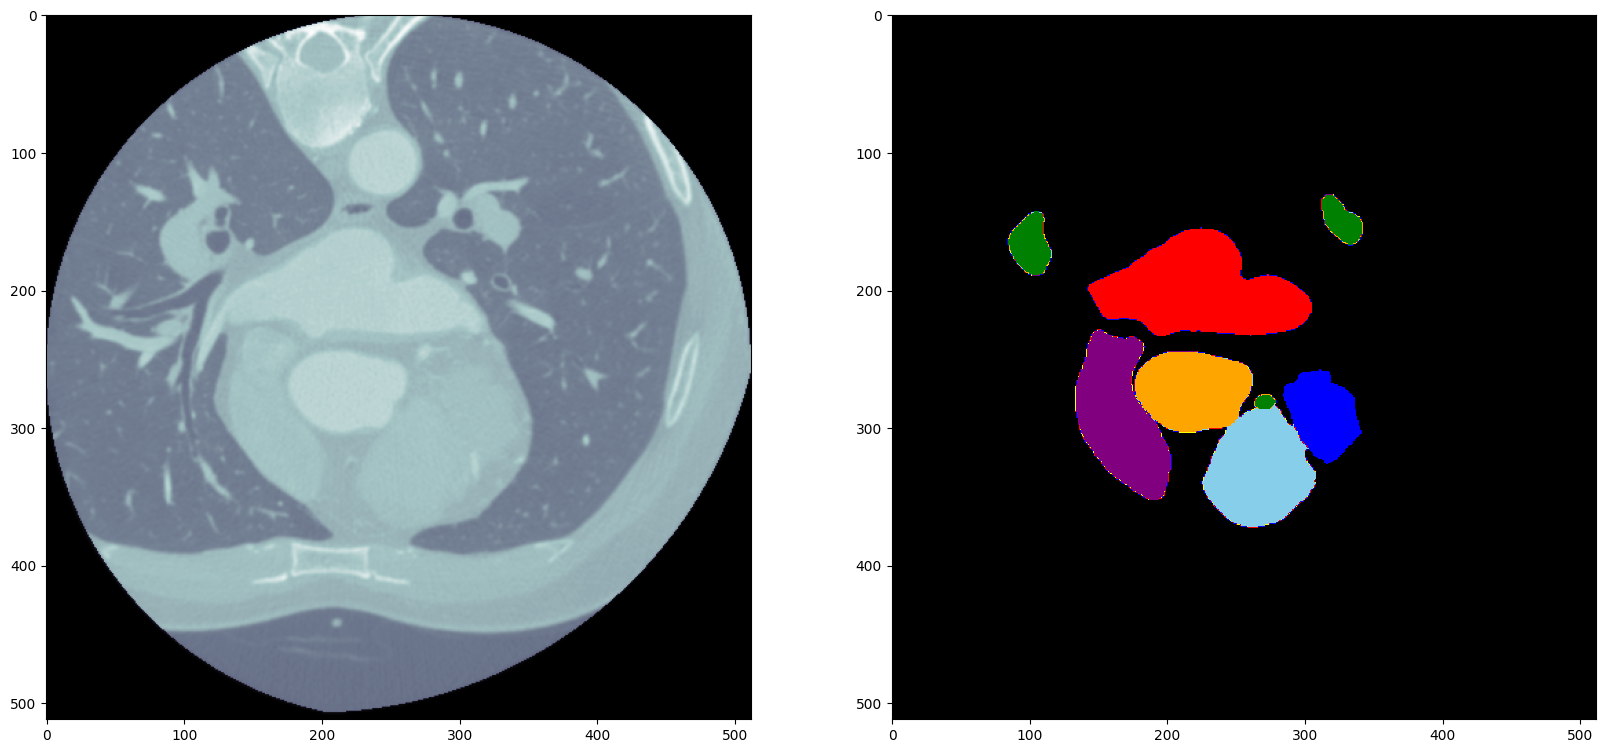

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

idx = 4
image = np.load(images[idx])
label = np.load(labels[idx])

ax[0].imshow(image[:,:,123].T, cmap='bone')
ax[1].imshow(label[:,:,123].T, cmap=custom_cmap, norm=norm)

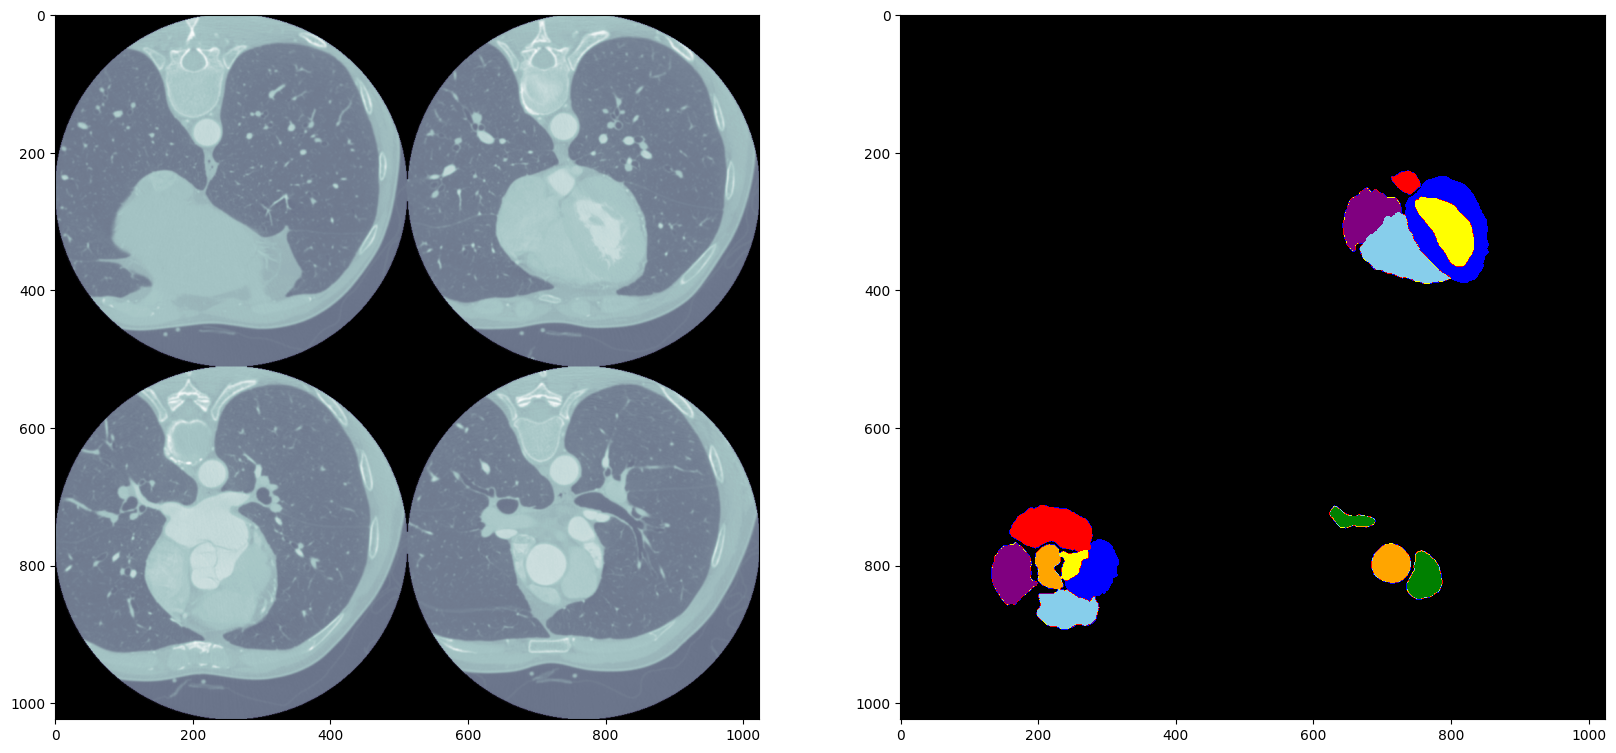

In [55]:
import skimage

idx = 1
image = np.load(images[idx])
label = np.load(labels[idx])

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(skimage.util.montage(image.T[50:300:50]), cmap='bone')
ax[1].imshow(skimage.util.montage(label.T[50:300:50]), cmap=custom_cmap, norm=norm)

## Визуализация 3D данных .nii

In [3]:
images = []
labels = []

for path in tqdm(sorted(os.listdir(DATASET_PATH))):
    if path.endswith("_image.nii"):
        image_path = os.path.join(DATASET_PATH, path)
        images.append(image_path)
    elif path.endswith("_label.nii"):
        label_path = os.path.join(DATASET_PATH, path)
        labels.append(label_path)

len(images), len(labels)

100%|██████████| 202/202 [00:00<00:00, 1163804.13it/s]


(20, 20)

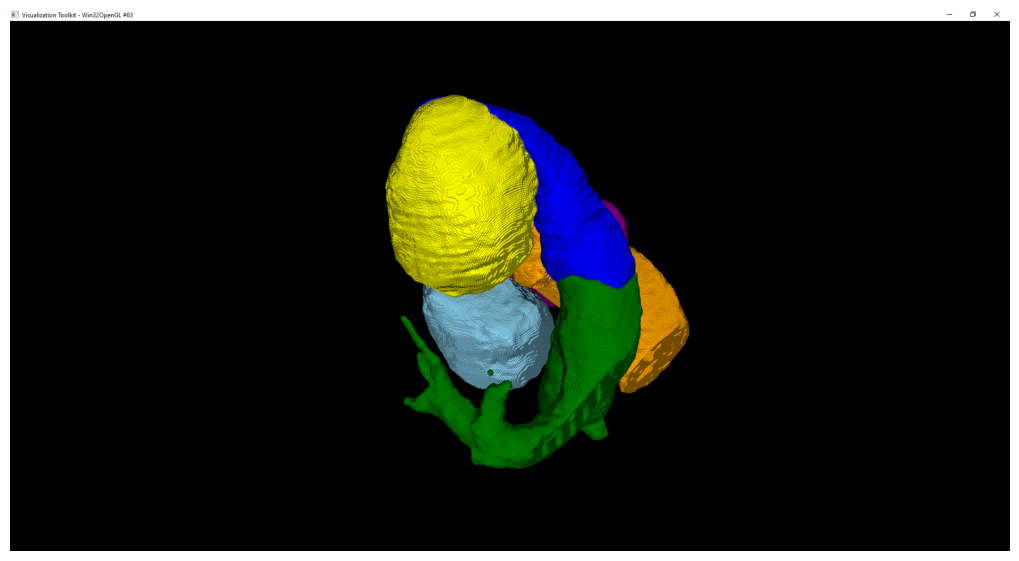

In [6]:
import vtk

def visualize_3d_scan_vtk(path_to_file: os.path, cmap, pixel_values: list, apply_cfilter: bool = False):
    reader = vtk.vtkNIFTIImageReader()
    reader.SetFileName(path_to_file)
    reader.Update()

    image = reader.GetOutput()

    actors = []
    pixel_values = pixel_values[1:]
    renderer = vtk.vtkRenderer()
    for i in range(len(pixel_values)):

        marching_cubes = vtk.vtkDiscreteMarchingCubes()
        marching_cubes.SetInputData(image)
        marching_cubes.SetValue(0, pixel_values[i])
        marching_cubes.Update()
        mc_image = marching_cubes.GetOutputPort()

        if apply_cfilter:
            confilter = vtk.vtkPolyDataConnectivityFilter()
            confilter.SetInputConnection(mc_image)
            confilter.SetExtractionModeToLargestRegion()
            confilter.Update()
            mc_image = confilter.GetOutputPort()

        lookup_table = vtk.vtkLookupTable()
        lookup_table.SetNumberOfTableValues(1)
        lookup_table.Build()
        val = vtk.vtkNamedColors().GetColor3d(cmap.colors[i])
        lookup_table.SetTableValue(0, val[0], val[1], val[2], 1.0)

        mapper = vtk.vtkPolyDataMapper()
        mapper.AddInputConnection(mc_image)
        mapper.SetLookupTable(lookup_table)
        actor = vtk.vtkActor()
        actor.SetMapper(mapper)

        actors.append(actor)

        renderer.AddActor(actors[-1])

    window = vtk.vtkRenderWindow()
    window.AddRenderer(renderer)

    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(window)
    interactor.Initialize()
    renderer.Render()
    window.Render()
    interactor.Start()


visualize_3d_scan_vtk(labels[0], cmap=custom_cmap, pixel_values=label_values)
image = plt.imread("./figures/vtk.png")
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
ax.imshow(image)

In [19]:
idx = 0
image = nib.load(images[idx]).get_fdata()
label = nib.load(labels[idx]).get_fdata()

image.shape, label.shape

((512, 512, 363), (512, 512, 363))

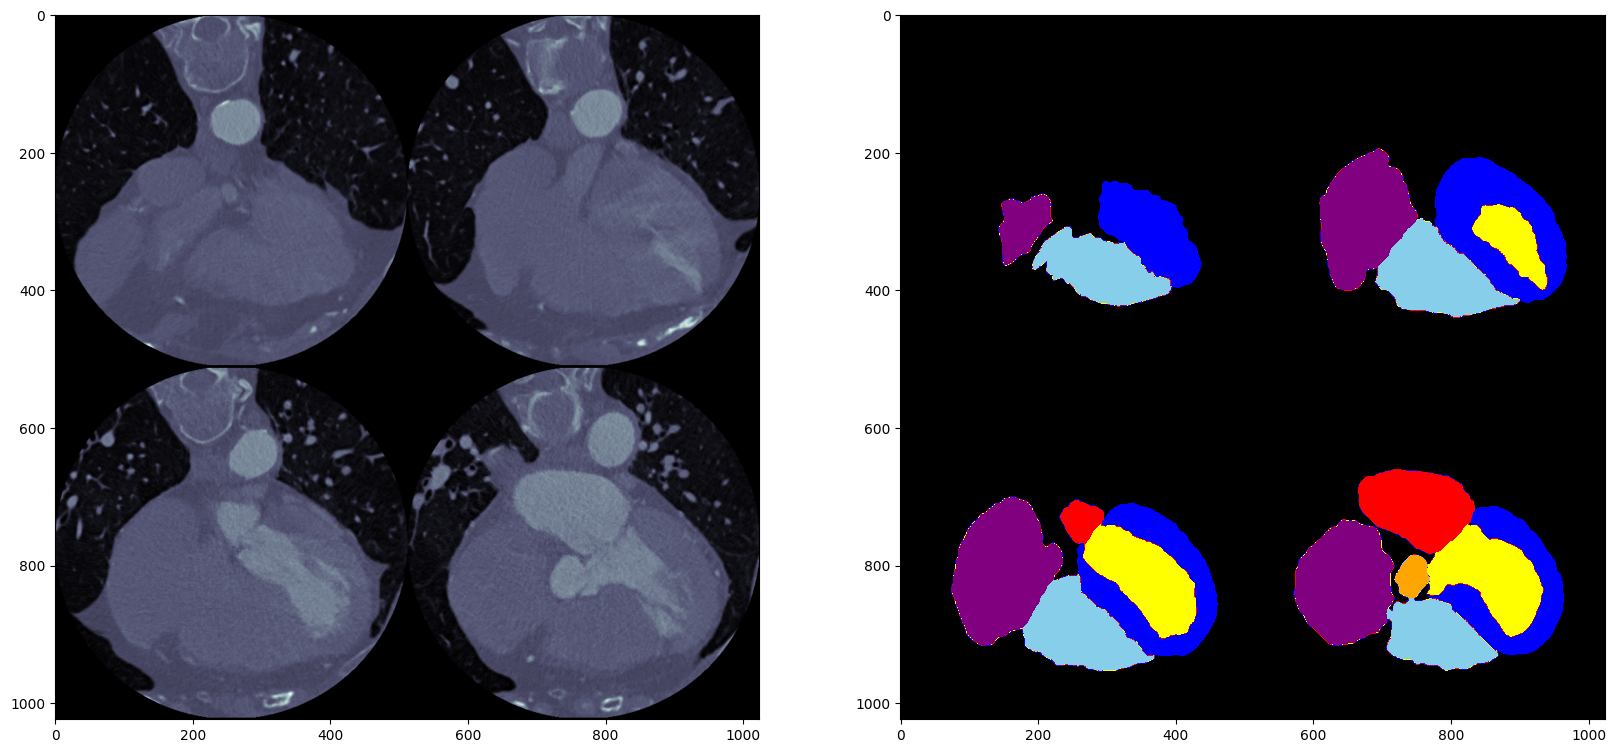

In [20]:
import skimage

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(skimage.util.montage(image.T[100:200:25]), cmap='bone')
ax[1].imshow(skimage.util.montage(label.T[100:200:25]), cmap=custom_cmap, norm=norm)

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import skimage
import matplotlib.pyplot as plt

def show_3d_scan(image: nib.Nifti1Image):

    image = np.rot90(image, k=2, axes=(0, 1))
    verts, faces, *_ = skimage.measure.marching_cubes(image, 650)
    
    mesh = Poly3DCollection(verts[faces], facecolors='cyan')

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.add_collection3d(mesh)

    plt.show()

show_3d_scan(image)